## Семинар №1. Авторегрессионные модели, PixelCNN

На семинаре мы рассмотрим авторегрессионные модели как один из классов генеративных моделей, разберёмся с их теорией и посмотрим, как можно применить их для генерации изображений.

### План:

- ##### Задача генеративных моделей
- ##### Теория авторегрессионных моделей
- ##### Авторегрессионные модели для изображений
- ##### PixelCNN
- ##### Gated PixelCNN

### Генеративные модели
Основная задача любой генеративной модели заключается в том, чтобы научиться аппроксимировать истинное распределение данных $p_{data}(\mathbf{x})$. Проще говоря, наша модель $p_{\boldsymbol{\theta}}(\mathbf{x})$ должна быть способна генерировать данные, которые похожи на те, на которых она обучалась.

Авторегрессионные модели — это один из классов таких генеративных моделей. Они достигают этой цели, максимизируя правдоподобие обучающих данных. Мы ищем ​
такие параметры $\boldsymbol{\theta}$, которые максимизируют правдоподобие $p(\mathbf{X} | \boldsymbol{\theta})$ обучающего набора данных $\mathbf{X} =\{\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N\}$:

$$\boldsymbol{\theta}^* = \underset{\theta}{\arg max} \log p(\mathbf{X} | \boldsymbol{\theta}) = \underset{\theta}{\arg max} \sum_{i=1}^n \log p(\mathbf{x}_i | \boldsymbol{\theta})$$

​Однако, прямое вычисление правдоподобия $p_{\boldsymbol{\theta}}(\mathbf{x})$ для объекта $\mathbf{x}$ — это крайне трудная задача.

### Авторегрессионные модели

Вместо того чтобы пытаться смоделировать сразу всю многомерную плотность, авторегрессионные модели используют разложение совместной вероятности на произведение условных:

$$p(x_1, x_2,..., x_D| \boldsymbol{\theta}) = p(x_1​∣\boldsymbol{\theta})\cdot p(x_2​∣x_1​,\boldsymbol{\theta})\cdotp(x_3​∣x_1​,x_2​,\boldsymbol{\theta})\cdot...\cdot p(x_D​∣x_1​,x_2​,...,x_{D−1}​,\boldsymbol{\theta}) = \prod_{j=1}^Dp(x_j|\mathbf{x}_{1:j-1},\boldsymbol{\theta}),$$

где $\mathbf{x}_{1:j-1} = [x_1,x_2,...,x_{j-1}]$ ​представляет собой вектор всех компонент объекта $\mathbf{x}$ до позиции $j$.

​По сути, мы предсказываем каждый следующий элемент, основываясь на всех предыдущих.

Благодаря этому разложению, задача максимизации правдоподобия для всего набора данных принимает гораздо более понятный и вычислительно трактуемый вид:

$$\boldsymbol{\theta}^* = \underset{\theta}{\arg max} \sum_{i=1}^n \left[\sum_{j=1}^D\log p_{\boldsymbol{\theta}}(x_{ij}|\mathbf{x}_{i,1:j-1})\right]$$

​
Здесь внешний суммирование происходит по $n$ объектам в обучающем наборе данных, а внутреннее — по $D$ компонентам каждого объекта. $x_{ij}$ обозначает $j$-ю компоненту $i$-го объекта, а $\mathbf{x}_{i,1:j-1}$ — это вектор предыдущих $j−1$ компонент $i$-го объекта.

**Как нам реализовать эту идею для изображений?**

### AR модели для изображений

Основная задача AR моделей при работе с изображениями — научиться предсказывать распределение вероятности $p_{\boldsymbol{\theta}}(\mathbf{x})$ для каждого изображения $\mathbf{x}$, состоящего из $n\times n$ пикселей.

Мы можем представить изображение $\mathbf{x}$ как одномерную последовательность $x_1,x_2,...,x_{n^2}$, где пиксели упорядочиваются согласно некоторому выбранному порядку. Обычно используют **классический растровый порядок** (**raster scan order**), когда пиксели упорядочиваются слева направо в каждой строке.

Чтобы оценить распределение $p_{\boldsymbol{\theta}}(\mathbf{x})$, мы используем авторегрессионное разложение, записывая его как произведение условных распределений по пикселям:

$$p_{\boldsymbol{\theta}}(\mathbf{x}) = \prod_{j=1}^{n^2}p_{\boldsymbol{\theta}}(x_j|\mathbf{x}_{1:j-1}),$$

где $p_{\boldsymbol{\theta}}(x_j|\mathbf{x}_{1:j-1})$ — это вероятность $j$-го пикселя $x_j$ при условии всех предыдущих пикселей $\mathbf{x}_{1:j-1}$.

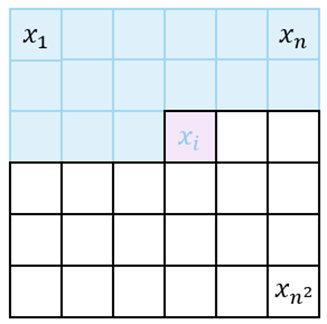

Каждый пиксель $x_j$ в цветном изображении в свою очередь определяется тремя значениями RGB, поэтому мы можем переписать условное распределение $p_{\boldsymbol{\theta}}(x_j|\mathbf{x}_{1:j-1})$ как следующее произведение:

$$p_{\boldsymbol{\theta}}(x_j|\mathbf{x}_{1:j-1}) = p_{\boldsymbol{\theta}}(x_{j,R}|\mathbf{x}_{1:j-1})\cdot p_{\boldsymbol{\theta}}(x_{j,G}|\mathbf{x}_{1:j-1}, x_{j,R})\cdot p_{\boldsymbol{\theta}}(x_{j,B}|\mathbf{x}_{1:j-1}, x_{j,R}, x_{j,G})$$

In [1]:
import itertools
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid  
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"

### Dataset

Для обучения нашей модели мы будем использовать датасет `MNIST`. Он состоит из $70 000$ изображений рукописных цифр от $0$ до $9$. Каждое изображение является одноканальным и имеет размер $28\times28$ пикселей.

- $60 000$ - Train Set
- $10 000$ - Test Set

In [2]:
from torchvision.datasets import MNIST

Прежде чем подавать изображения в нейронную сеть, нам нужно их подготовить. Определим преобразования, которые будут конвертировать изображения в тензоры и нормализовывать их:

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

Создадим датасеты для обучения и валидации и на их основе подготовим даталоадеры.

In [4]:
train_dataset = MNIST(root='./data', train=True, transform=transform)
val_dataset = MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

### PixelCNN

Обычные свёртки, которые применяются к изображению, могут видеть все соседние пиксели, в том числе и будущие. Это нарушает причинно-следственную связь, ведь мы не должны использовать информацию из будущих пикселей. Чтобы решить эту проблему, в PixelCNN предложили использовать **маскированные свертки** (**masked convolutions**).

#### Masked Convolution

Идея маскированной свертки проста: **на ядро свёртки** накладывается бинарная маска, которая обнуляет все веса, отвечающие за связи с **будущими** пикселями. В итоге, при вычислении значения для текущего пикселя $x_i$, свертка будет учитывать только те пиксели, которые были сгенерированы до него в соответствии с порядком.

Бонусом мы повышаем **эффективность обучения**, поскольку в отличие от RNN свертки легко распараллеливаются на GPU.

**Во время обучения модель получает на вход сразу всё изображение.**

#### Маски типа A и B

В PixelCNN используются два типа масок:

- **Маска A** применяется только к первому сверточному слою и запрещает текущему пикселю видеть и себя, и будущие пиксели
- **Маска B** используется для всех последующих слоев и разрешает ядру видеть центральный пиксель

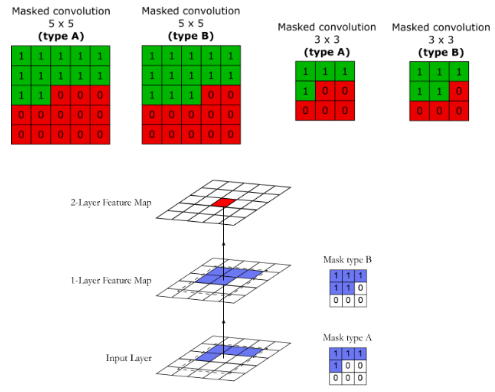

**Можно ли всегда использовать маски типа А?**

In [5]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=5):
        super().__init__(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        
        self.register_buffer("mask", torch.zeros_like(self.weight))    # non-learnable mask buffer
        self._create_mask(mask_type)

    def _create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1                    # allow rows above center
        self.mask[:, :, k // 2, :k // 2] = 1            # allow cols left of center
        if mask_type == "B":
            self.mask[:, :, k // 2, k // 2] = 1

    def forward(self, x):
        masked_weight = self.weight * self.mask                                # apply mask to weights
        return F.conv2d(x, masked_weight, self.bias, padding=self.padding)

**Почему $padding = kernel\; size // 2$ ?**

In [6]:
conv = MaskedConv2d("A", in_channels=1, out_channels=1, kernel_size=3)
print(conv.mask)

tensor([[[[1., 1., 1.],
          [1., 0., 0.],
          [0., 0., 0.]]]])


In [7]:
conv = MaskedConv2d("B", in_channels=1, out_channels=1, kernel_size=3)
print(conv.mask)

tensor([[[[1., 1., 1.],
          [1., 1., 0.],
          [0., 0., 0.]]]])


### Архитектура PixelCNN

Архитектура PixelCNN состоит из следующих основных частей:

- **Первый слой**: маскированная свертка типа А с фильтром размера $7\times 7$
- **15 ResNet блоков**: комбинация из сверточных слоев $3\times 3$ с маской типа B и стандартных (немаскированных) сверточных слоев $1\times 1$, между каждым сверточным слоем  применяется ReLU
- **Финальные слои**: два сверточных слоя с фильтрами $1\times 1$, также использующие маску B и активации ReLU
- **Выходной Softmax-слой**: предсказывает категориальное распределение для каждого пикселя
  
(первый блок $7 \times 7$)

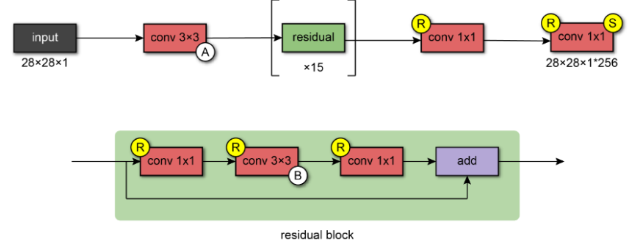

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, hidden_channels):
        super().__init__()
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv2d(channels, hidden_channels, kernel_size=1)

        self.relu2 = nn.ReLU()
        self.masked_conv = MaskedConv2d("B", hidden_channels, hidden_channels, kernel_size=3)

        self.relu3 = nn.ReLU()
        self.conv2 = nn.Conv2d(hidden_channels, channels, kernel_size=1)

    def forward(self, x):
        out = self.relu1(x)
        out = self.conv1(out)

        out = self.relu2(out)
        out = self.masked_conv(out)

        out = self.relu3(out)
        out = self.conv2(out)
        return out + x

In [10]:
class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=128, residual_hidden=64,
                 num_classes=256, num_residual_blocks=15, kernel_size=7):
        super().__init__()

        self.initial = MaskedConv2d("A", input_channels, hidden_channels, kernel_size=kernel_size)

        self.res_blocks = nn.Sequential(*[
            ResidualBlock(hidden_channels, residual_hidden)
            for _ in range(num_residual_blocks)
        ])

        self.final = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, num_classes, kernel_size=1)
        )

    def forward(self, x):
        out = self.initial(x)
        out = self.res_blocks(out)
        out = self.final(out)       # logits: [B, num_classes, H, W]
        return out

**Можно ли использовать нормализацию?**

In [11]:
model = PixelCNN(
    input_channels=1,
    hidden_channels=128,
    residual_hidden=64,
    num_classes=256,
    num_residual_blocks=15,
    kernel_size=7
)

model.to(device)

x, *_ = next(iter(train_loader))
x = x.to(device)

with torch.no_grad():
    logits = model(x)

print(f"logits.shape = {logits.shape}")

logits.shape = torch.Size([512, 256, 28, 28])


In [12]:
def sample(model, num_samples, num_channels, height, width, device, temperature=1.0):

    samples = torch.zeros(num_samples, num_channels, height, width, device=device)

    with torch.no_grad():
        for row, col in itertools.product(range(height), range(width)):          # Fill pixels in raster scan order
            logits = model(samples)                                              # (N, num_classes, H, W)

            logits_at_pixel = logits[:, :, row, col] / temperature               # Select logits at the current pixel  
            probs = F.softmax(logits_at_pixel, dim=1)
            
            pixel_value = torch.multinomial(probs, num_samples=1).squeeze(-1)
            samples[:, 0, row, col] = pixel_value.float() / 255.0                # Normalize sampled value to [0,1]

    return samples.cpu()

### Training and Validation Loop

In [13]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for images, _ in tqdm(train_loader, desc="Train"):
        images = images.to(device)                      # (B, C, H, W)

        targets = (images * 255).long().squeeze(1)      # Convert normalized [0,1] images to integer targets [0,255]

        optimizer.zero_grad()
        logits = model(images)                          # (B, num_classes, H, W)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc="Val"):
            images = images.to(device)
            targets = (images * 255).long().squeeze(1)

            logits = model(images)
            loss = criterion(logits, targets)
            total_loss += loss.item()

    return total_loss / len(val_loader)

In [14]:
def save_checkpoint(model, epoch, path_template):
    save_path = path_template.format(epoch=epoch+1)

    save_dir = os.path.dirname(save_path)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    torch.save(model.state_dict(), save_path)
    print(f"Checkpoint saved: {save_path}")

def plot_losses(train_losses, val_losses):
    clear_output(wait=True)
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_samples(model, val_loader, device, num_samples=5, temperature=1.0):
    example_batch = next(iter(val_loader))[0]
    num_channels = example_batch.size(1)
    height, width = example_batch.size(2), example_batch.size(3)

    samples = sample(model, num_samples, num_channels, height, width, device, temperature)

    grid = make_grid(samples, nrow=min(num_samples, 8), padding=2)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Samples")
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

In [15]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion,
                       checkpoint_path, device, epochs=10, sample_every=1,
                       num_samples=5, temperature=1.0):
    
    model.to(device)
    train_loss_history, val_loss_history = [], []

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        train_loss_history.append(train_loss)

        val_loss = validate_one_epoch(model, val_loader, criterion, device)
        val_loss_history.append(val_loss)

        print(f"\nEpoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        plot_losses(train_loss_history, val_loss_history)
        save_checkpoint(model, epoch, f"{checkpoint_path}/pixelcnn_epoch{{epoch}}.pt")

        if (epoch + 1) % sample_every == 0:
            plot_samples(model, val_loader, device, num_samples=num_samples, temperature=temperature)

In [16]:
epochs = 15
lr = 1e-3
checkpoint_path = "checkpoints_pixelcnn"

model = PixelCNN(
    input_channels=1,
    hidden_channels=128,
    residual_hidden=64,
    num_classes=256,
    num_residual_blocks=15,
    kernel_size=7
)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

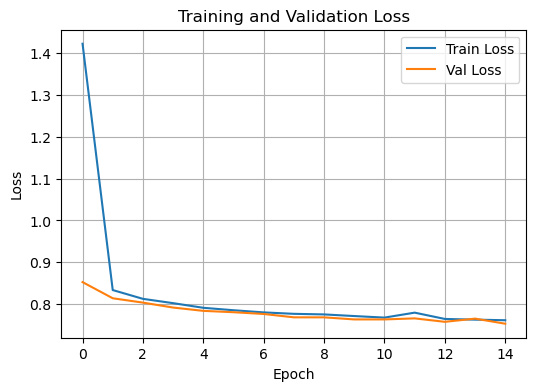

Checkpoint saved: checkpoints_pixelcnn/pixelcnn_epoch15.pt


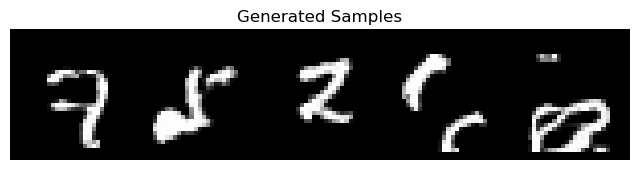

In [17]:
train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    checkpoint_path=checkpoint_path,
    device=device,
    epochs=epochs,
    sample_every=1,     
    num_samples=5,
    temperature=1.0
)

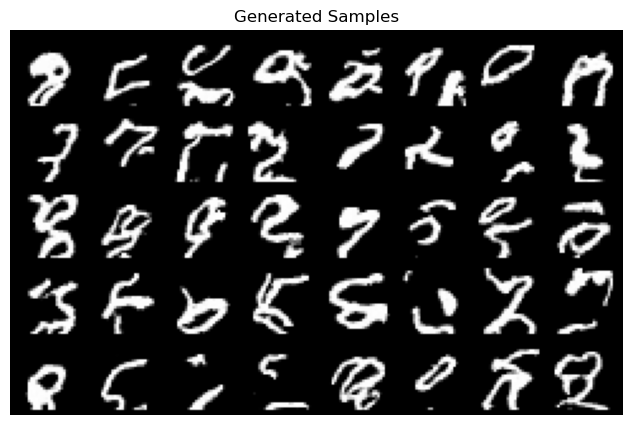

In [18]:
model.load_state_dict(torch.load("checkpoints_pixelcnn/pixelcnn_epoch10.pt", map_location=device))
model.to(device)

num_samples = 40
num_channels = 1  
height, width = 28, 28  

samples = sample(model, num_samples, num_channels, height, width, device, temperature=1.0)

grid = make_grid(samples, nrow=8, padding=2)
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.title("Generated Samples")
plt.imshow(grid.permute(1, 2, 0))
plt.show()

### Слепое пятно

Классическая реализация **PixelCNN** имеет проблему, известную как **слепое пятно** (**blind spot**). Это области входного изображения, которые модель не видит при предсказании текущего пикселя.

Из-за формы маски область, которую «видит» модель (**receptive field**) для каждого пикселя ограничено. 

В итоге, модель теряет значительную часть полезного контекста.

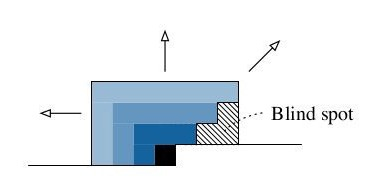



### Gated PixelCNN

Чтобы исправить проблему слепого пятна, в [Gated PixelCNN](https://arxiv.org/pdf/1606.05328) архитектуру разделилли на два независимых, но взаимодействующих стека, которые обрабатывают информацию по-разному:

- **Vertical stack**: смотрит только на пиксели выше текущего, это позволяет ему собирать информацию со всех вышележащих строк, включая ту часть, которая была слепым пятном.

- **Horizontal stack**: смотрит только на пиксели слева в текущей строке и **получает информацию от вертикального стека**.

Такое разделение полностью устраняет слепые зон и вместе они обеспечивают полный доступ ко всему ранее сгенерированному контексту.

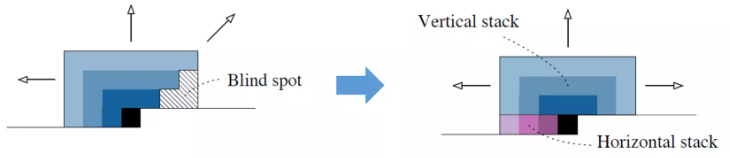

In [19]:
class MaskedConvolution(nn.Conv2d):
    def __init__(self, in_channels, out_channels, mask, **kwargs):
        kh, kw = mask.shape
        super().__init__(
            in_channels, out_channels, (kh, kw), **kwargs
        )
        mask_full = mask.view(1, 1, kh, kw).expand_as(self.weight)
        self.register_buffer("mask", mask_full)

    def forward(self, x):
        return F.conv2d(
            x, self.weight * self.mask, self.bias,
            padding=self.padding,
        )

In [21]:
class VerticalStack(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size=3, mask_center=False, **kwargs):
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size // 2 + 1 :, :] = 0               # Zero out any rows below the center row
        if mask_center:
            mask[kernel_size // 2, :] = 0
        super().__init__(in_channels, out_channels, mask, padding=(kernel_size // 2, kernel_size // 2), **kwargs)

class HorizontalStack(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size=3, mask_center=False, **kwargs):
        mask = torch.ones(1, kernel_size)
        mask[0, kernel_size // 2 + 1 :] = 0               # Zero out any columns strictly to the right of the center
        if mask_center:
            mask[0, kernel_size // 2] = 0  
        super().__init__(in_channels, out_channels, mask, padding=(0, kernel_size // 2), **kwargs)

In [22]:
v_stack_B = VerticalStack(1, 1, kernel_size=5, mask_center=True)
print(v_stack_B.mask) 

tensor([[[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])


In [23]:
h_stack_B = HorizontalStack(1, 1, kernel_size=5, mask_center=True)
print(h_stack_B.mask) 

tensor([[[[1., 1., 0., 0., 0.]]]])


### Gated Convolutional Layers

Еще одним улучшением стала замена стандартных ReLU-активаций на специальный **вентильный активационный блок** (**gated activation unit**):

$$\mathbf{y} =\tanh (\mathbf{W}_{k,f}*\mathbf{x}) \odot \sigma(\mathbf{W}_{k,g}*\mathbf{x})$$

$\tanh$ — гиперболический тангенс

$\mathbf{x}$ — входной тензор

$∗$ — операция свертки

$\mathbf{W}_{k,f}, \mathbf{W}_{k,g}$ — веса сверточных фильтров

$\sigma$ — сигмоида

$\odot$ — поэлементное умножение

На схеме одного **Gated блока** показано, как вертикальные $v$ и горизонтальные $h$ потоки данных обрабатываются внутри одного слоя для получения их обновленных версий $v'$и $h'$:

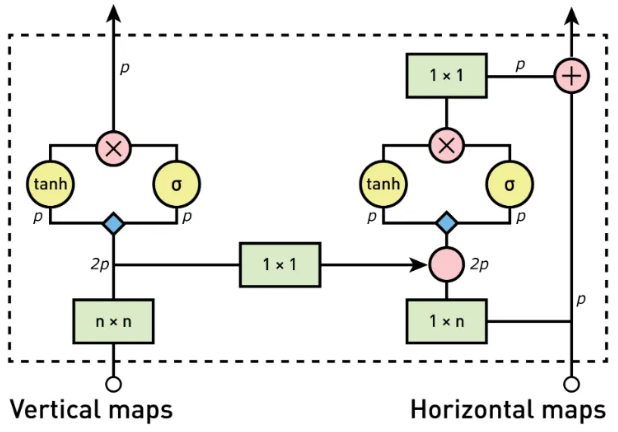



- <span style="color:green">Маскированные свёртки</span> — показаны **зелёным**.
- <span style="color:red">Покомпонентны) операции</span> — показаны **красным**.
- <span style="color:deepskyblue">Свёртки с весами W<sub>f</sub>, W<sub>g</sub>, объединённые в одну операцию</span> — показаны **голубым**

Работу одного Gated блока можно разбить на четыре последовательных шага:

1. **Вычисление вертикальных карт признаков $v'$**:
   - На вход приходит выход вертикального стека с предыдущего слоя $v$
   - К нему применяется свёртка $n\times n$ c **gated activation unit**
   - На выходе получаем новые карты признаков $v'$
  
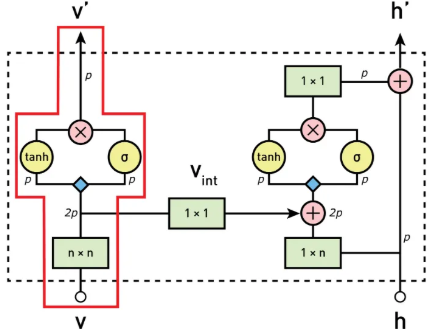

2. **Передача вертикальных карт в горизонтальный стек**:
   - На вход поступает выход $n \times n$ свёртки, применённой к $v$
   - Применяется свёртка $1 \times 1$
   - На выходе получаем $v_{int}$

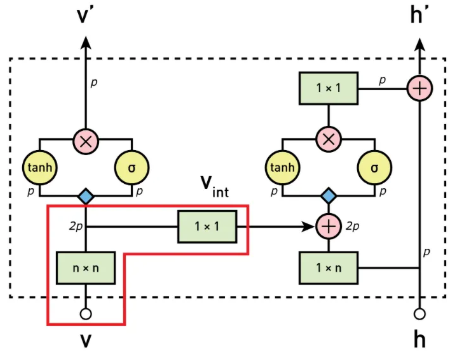

3. **Вычисление горизонтальных карт признаков**:
   - На вход приходит выход горизонтального стека с предыдущего слоя $h$ и обработанные карты из вертикального стека $v_{int}$
   - К входу $h$ применяется свертка $1\times n$, результат складывается с $v_{int}$. Затем эта сумма проходит через **gated activation unit**
   - На выходе получаем промежуточные карты горизонтального стека $h_i$

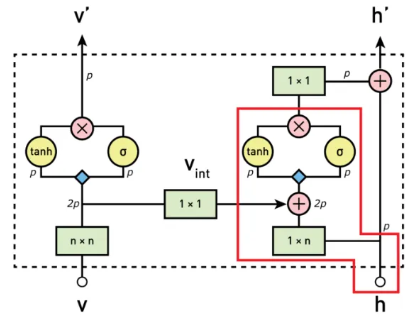

4. **Вычисление остаточного соединения**:
   - На входе промежуточные карты $h_i$ и исходный входной сигнал горизонтального стека $h$.
   - К $h_i$ применяется свертка $1\times1$, результат прибавляется к исходному $h$.
   - На выходе получаем карты признаков горизонтального стека $h'$
  
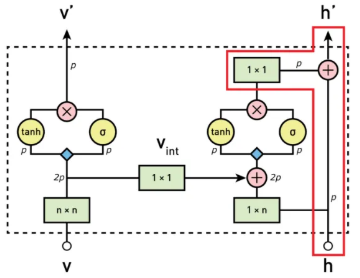


### Conditional Gated PixelCNN

Чтобы генерировать изображение конкретного класса, была предложена условная версия модели. Идея состоит в том, чтобы подать в модель некоторую дополнительную информацию $\mathbf{h}$ (вектор условия).

Это достигается путем модификации формулы вентильной активации:

$$\mathbf{y} =\tanh (\mathbf{W}_{k,f}*\mathbf{x} + \mathbf{V}^T_{k,f}\mathbf{h}) \odot \sigma(\mathbf{W}_{k,g}*\mathbf{x} + \mathbf{V}^T_{k,g}\mathbf{h})$$

Как видно из формулы, вектор условия $\mathbf{h}$ после линейного преобразования с матрицей весов $V^T$ добавляется к результату свертки перед применением нелинейностей. 

Таким образом, модель предсказывает не просто $p(\mathbf{x})$, а условное распределение $p(\mathbf{x}∣\mathbf{h})$.

In [24]:
class GatedMaskedConv(nn.Module):
    def __init__(self, c_in, label_classes, kernel_size=3, mask_center=False):
        super().__init__()
        
        self.conv_vert  = VerticalStack(c_in, 2 * c_in, kernel_size, mask_center=mask_center)
        self.conv_horiz = HorizontalStack(c_in, 2 * c_in, kernel_size, mask_center=mask_center)
        self.vert_to_horiz = nn.Conv2d(2 * c_in, 2 * c_in, kernel_size=1)
        
        self.horiz_out = nn.Conv2d(c_in, c_in, kernel_size=1)
        self.skip_conv = nn.Conv2d(c_in, c_in, kernel_size=1)

        self.class_emb = nn.Embedding(label_classes, 2 * c_in)

    def forward(self, v_in, h_in, class_id):
        B, C, H, W = h_in.shape

        cond = self.class_emb(class_id)                             # (B, 2*C)
        cond = cond.unsqueeze(2).unsqueeze(3)                       # (B, 2*C, 1, 1)
        
        # Vertical branch 
        v_feat = self.conv_vert(v_in) + cond                        # (B, 2C, H, W)
        v_val, v_gate = v_feat.chunk(2, dim=1)                      # split into 2 tensors of shape (B, C, H, W)
        v_out = torch.tanh(v_val) * torch.sigmoid(v_gate)           # (B, C, H, W)

        # Horizontal branch
        h_feat = self.conv_horiz(h_in) + self.vert_to_horiz(v_feat) + cond   # (B, 2C, H, W)
        h_val, h_gate = h_feat.chunk(2, dim=1)
        h_act = torch.tanh(h_val) * torch.sigmoid(h_gate)                    # (B, C, H, W)

        # residual + skip
        h_out = h_in + self.horiz_out(h_act)
        skip  = self.skip_conv(h_act)

        return v_out, h_out, skip

### Gated PixelCNN

Итоговая модель представляет собой последовательность из нескольких слоев Gated блоков:

- Входное изображение сначала проходит через маскированную свертку

- Затем обрабатывается несколькими Gated блоками

- После этого могут идти дополнительные слои (голова).

- В конце Softmax-слой, который генерирует итоговое распределение для предсказания пикселей.

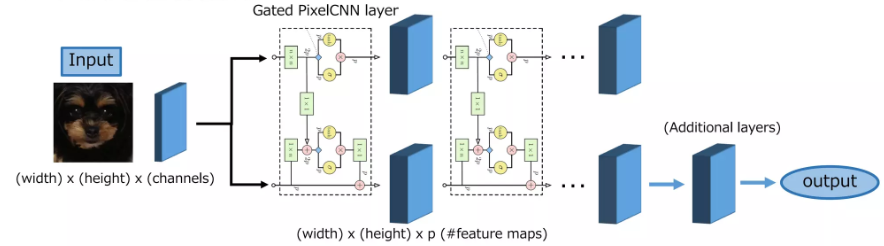

In [26]:
class GatedPixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, n_layers=7, kernel_size=3, pixel_bins=256, label_classes=10):   
        super().__init__()

        self.init_vert  = VerticalStack(input_channels, hidden_channels, kernel_size, mask_center=True)
        self.init_horiz = HorizontalStack(input_channels, hidden_channels, kernel_size, mask_center=True)

        self.blocks = nn.ModuleList([
            GatedMaskedConv(hidden_channels, label_classes, kernel_size, mask_center=False)
            for _ in range(n_layers)
        ])

        self.output_head = nn.Sequential(
            nn.ELU(inplace=True),
            nn.Conv2d(hidden_channels, pixel_bins, kernel_size=1)
        )

    def forward(self, x, class_id):
        # init branches
        v, h = self.init_vert(x), self.init_horiz(x)

        skip_total = torch.zeros_like(h)
        for block in self.blocks:
            v, h, skip = block(v, h, class_id)
            skip_total = skip_total + skip

        out = self.output_head(skip_total)             # (B, pixel_bins, H, W)
        return out

### Sampling

In [25]:
def sample(model, num_samples, num_channels, height, width, device,
           temperature=1.0, class_id=None):
    
    samples = torch.zeros(num_samples, num_channels, height, width, device=device)

    if class_id is None:
        class_id = torch.zeros(num_samples, dtype=torch.long, device=device)
    else:
        class_id = class_id.to(device)

    with torch.no_grad():
        for row in range(height):
            for col in range(width):
                logits = model(samples, class_id)                          # (N, pixel_bins, H, W)
                logits_at_pixel = logits[:, :, row, col] / temperature
                probs = F.softmax(logits_at_pixel, dim=1)
                pixel_value = torch.multinomial(probs, num_samples=1).squeeze(-1)  # (N,)
                samples[:, 0, row, col] = pixel_value.float() / 255

    return samples.cpu()

### Train and Validation Loop

In [27]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train"):
        images = images.to(device)
        labels = labels.to(device)  

        targets = (images * 255).long().squeeze(1)

        optimizer.zero_grad()
        logits = model(images, labels)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Val"):
            images = images.to(device)
            labels = labels.to(device)

            targets = (images * 255).long().squeeze(1)
            logits = model(images, labels)
            loss = criterion(logits, targets)
            total_loss += loss.item()

    return total_loss / len(val_loader)

In [28]:
def plot_samples(model, val_loader, device, num_samples=5, temperature=1.0):
    batch = next(iter(val_loader))

    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
        images, labels = batch[0], batch[1]
        labels = labels[:num_samples].to(device)
    else:
        images = batch
        labels = torch.zeros(num_samples, dtype=torch.long, device=device)

    num_channels = images.size(1)
    height, width = images.size(2), images.size(3)

    samples = sample(model, num_samples, num_channels, height, width, device, temperature, class_id=labels)

    plt.figure(figsize=(num_samples * 2, 2.5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = samples[i].permute(1, 2, 0).numpy()
        plt.imshow(img, cmap="gray" if num_channels == 1 else None)
        plt.title(f"Class {labels[i].item()}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [29]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion,
                       checkpoint_path, device, epochs=10, sample_every=1,
                       num_samples=5, temperature=1.0):
    
    model.to(device)
    train_loss_history, val_loss_history = [], []

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        train_loss_history.append(train_loss)

        val_loss = validate_one_epoch(model, val_loader, criterion, device)
        val_loss_history.append(val_loss)

        print(f"\nEpoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        plot_losses(train_loss_history, val_loss_history)
        save_checkpoint(model, epoch, f"{checkpoint_path}/pixelcnn_epoch{{epoch}}.pt")

        if (epoch + 1) % sample_every == 0:
            plot_samples(model, val_loader, device, num_samples=num_samples, temperature=temperature)

In [30]:
epochs = 15
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = "checkpoints_gatedpixelcnn"

model = GatedPixelCNN(
    input_channels=1,
    hidden_channels=64,
    n_layers=20,
    kernel_size=3, 
    pixel_bins=256,      
    label_classes=10
)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

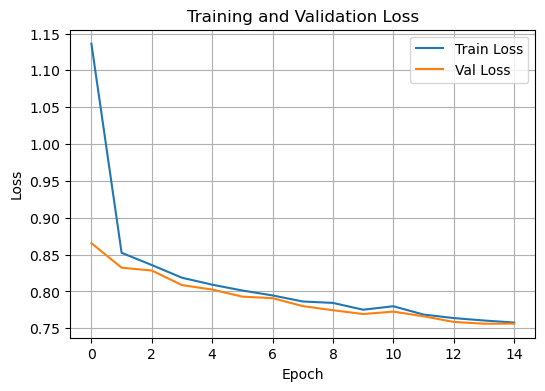

Checkpoint saved: checkpoints_gatedpixelcnn/pixelcnn_epoch15.pt


In [31]:
train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    checkpoint_path=checkpoint_path,
    device=device,
    epochs=epochs,
    sample_every=2,     
    num_samples=5,
    temperature=1.0
)

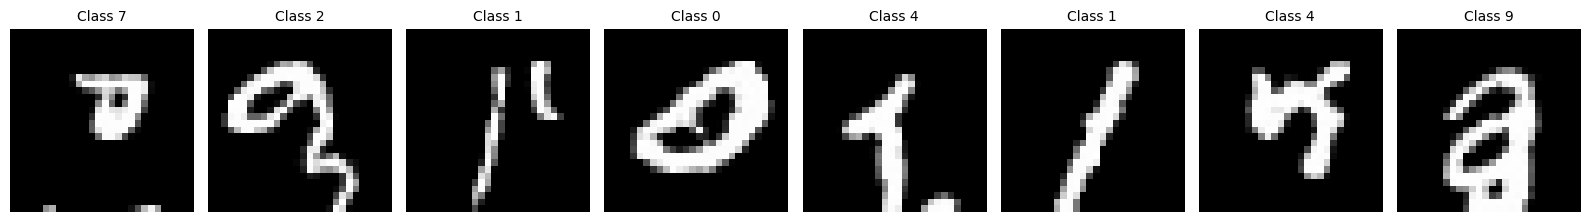

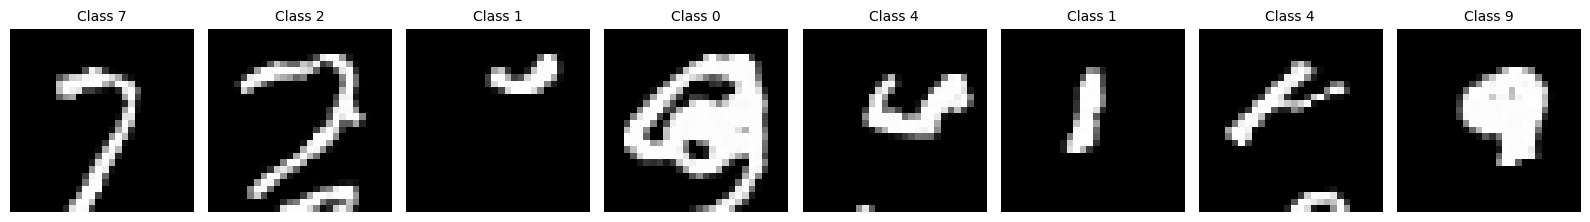

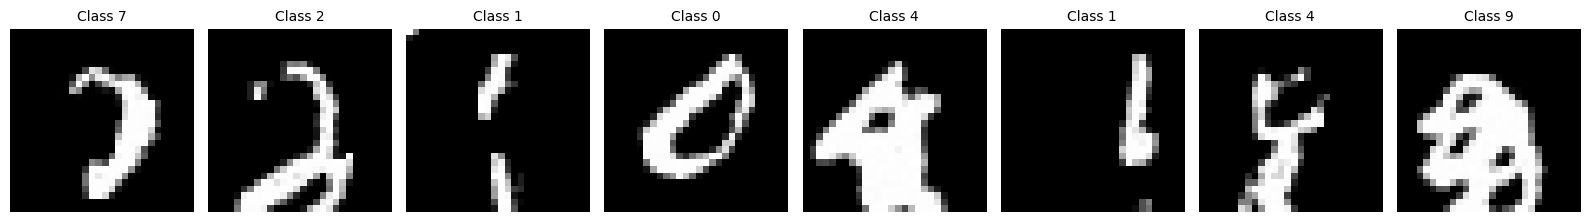

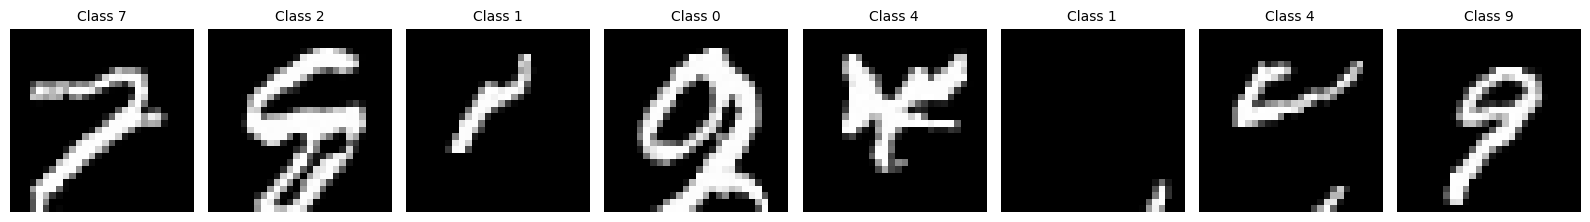

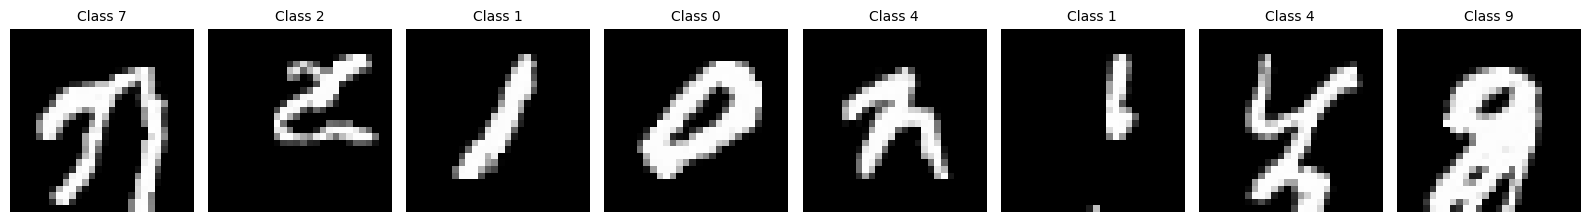

In [33]:
model.load_state_dict(torch.load("checkpoints_gatedpixelcnn/pixelcnn_epoch15.pt", map_location=device))
model.to(device)

for _ in range(5):
    plot_samples(
        model,
        val_loader,
        device,
        num_samples=8,  
        temperature=1.0
    )

### Проблема Gated PixelCNN

Для каждого пикселя модель предсказывает 1 из 256 классов.

Она не понимает, что значение пикселя 120 ближе к 121, чем к 250. Для неё все 256 значений были независимыми.

В модели [PixelCNN++](https://arxiv.org/abs/1701.05517) авторы предложили новую идею.

Они решили полностью отказаться от `Softmax` и вместо него предсказывать параметры для **смеси логистических распределений** (**discretized logistic mixture likelihood**).